In [1]:
!pip install --quiet --upgrade langchain langchain-community langgraph langchain_openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [16]:
from typing import Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from langchain.chat_models.base import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage

def get_llm():
    """Initialize the LLM with OpenRouter"""
    return init_chat_model(
        model="openai/gpt-oss-20b:free",
        model_provider="openai",
        base_url="https://openrouter.ai/api/v1",
        api_key="you api key",  # Replace with your key
        temperature=0.1,
        max_tokens=4096,
        model_kwargs={"top_p": 0.95}
    )

class RouteDecision(BaseModel):
    """
    LLM outputs this to decide where to route the user.

    Fields explained:
    - route: Which agent should handle this? ("booking", "info", or "unclear")
    """
    route: Literal["booking", "info", "unclear"] = Field(
        description="The category of the user's request"
    )


class AgentResponse(BaseModel):
    """
    Each agent outputs this as their response.

    Fields explained:
    - message: The actual text response shown to the user
    """
    message: str = Field(
        description="The response message to the user"
    )



class AgentState(TypedDict):
    """
    The "shared memory" that passes between nodes in the graph.
    Think of it like a form that gets filled out as it moves through agents.

    Fields explained:
    - user_input: What the user typed/said (INPUT - comes from user)
    - route: Which agent to use ("booking", "info", "unclear") (SET BY ROUTER)
    - response: The final answer to show the user (SET BY AGENT)
    """
    user_input: str
    route: str
    response: str


def router_node(state: AgentState) -> AgentState:
    """
    Intelligent router using LLM with structured output.
    Classifies user intent with confidence scoring.
    """
    llm = get_llm()
    structured_llm = llm.with_structured_output(RouteDecision)
    system_prompt = """You are an expert intent classifier for a customer service system.

    Analyze the user's message and classify it into one of these categories:

    1. **booking**: User wants to make a reservation, schedule an appointment, or book any service
      - Keywords: book, reserve, schedule, appointment, reservation, arrange
      - Examples: "I need to book a table", "Schedule an appointment", "Reserve a room"

    2. **info**: User is asking for information or has questions
      - Keywords: what, how, when, where, why, tell me, information, details, price, cost, hours
      - Examples: "What are your hours?", "How much does it cost?", "Where are you located?"

    3. **unclear**: User's intent is ambiguous or doesn't fit the above categories
      - Examples: "Hello", "Help", "I need assistance", vague statements

    Provide:
    - The route classification only
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User message: {state['user_input']}")
    ]
    decision: RouteDecision = structured_llm.invoke(messages)
    state["route"] = decision.route
    print(f"\n🧭 ROUTER → Routing to: {decision.route}")
    return state

def booking_agent(state: AgentState) -> AgentState:
    """
    Handles booking and reservation requests using LLM.
    """
    llm = get_llm()
    structured_llm = llm.with_structured_output(AgentResponse)

    system_prompt = """You are a booking specialist agent.
    Your job is to help users make reservations and schedule appointments.
    Guidelines:
    - Be friendly and professional
    - Ask for necessary details (date, time, number of people, etc.)
    - Confirm what type of booking they need
    - Provide clear next steps
    - If information is missing, politely ask for it
    Always structure your response with:
    - A helpful message only
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User request: {state['user_input']}\n\nHelp them with their booking.")
    ]
    response: AgentResponse = structured_llm.invoke(messages)
    state["response"] = response.message
    print(f"\n🎫 BOOKING AGENT → Generated response")
    return state


def info_agent(state: AgentState) -> AgentState:
    """
    Provides information and answers questions using LLM.
    """
    llm = get_llm()
    structured_llm = llm.with_structured_output(AgentResponse)

    system_prompt = """You are an information specialist agent.
    Your job is to answer user questions and provide helpful information.
    Knowledge base (use this to answer):
    - Business hours: Monday-Friday 9 AM - 6 PM, Saturday 10 AM - 4 PM, Closed Sunday
    - Location: 123 Main Street, Downtown City
    - Pricing: Basic ($50), Standard ($100), Premium ($150)
    - Services: Restaurant reservations, Hotel bookings, Event planning
    - Contact: info@example.com, (555) 123-4567
    Guidelines:
    - Provide accurate, specific information
    - Be concise but complete
    - If you don't have the information, suggest contacting support
    - Offer to help with related questions
    Always structure your response with:
    - A helpful message only
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User question: {state['user_input']}\n\nProvide the information they need.")
    ]

    response: AgentResponse = structured_llm.invoke(messages)

    state["response"] = response.message

    print(f"\nℹ️  INFO AGENT → Generated response")

    return state


def unclear_agent(state: AgentState) -> AgentState:
    """
    Handles unclear requests and helps clarify user intent.
    """
    llm = get_llm()
    structured_llm = llm.with_structured_output(AgentResponse)

    system_prompt = """You are a clarification specialist agent.

Your job is to help when user intent is unclear or ambiguous.

Guidelines:
- Be warm and welcoming
- Don't make the user feel bad for being unclear
- Present clear options for what you can help with
- Ask targeted questions to understand their needs
- Offer specific examples of what you can do

Capabilities you can offer:
1. Booking services (restaurants, hotels, appointments)
2. Information requests (hours, location, pricing, services)
3. General assistance and guidance

Always structure your response with:
- A friendly message with clear options only
"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User message: {state['user_input']}\n\nHelp clarify what they need.")
    ]

    response: AgentResponse = structured_llm.invoke(messages)

    state["response"] = response.message

    print(f"\n🤔 CLARIFICATION AGENT → Generated response")

    return state


def route_to_agent(state: AgentState) -> Literal["booking", "info", "unclear"]:
    """
    Conditional edge function that determines which agent to invoke.
    """
    return state["route"]


def create_agent_graph():
    """
    Builds the LangGraph workflow with LLM-powered routing.
    """
    workflow = StateGraph(AgentState)

    workflow.add_node("router", router_node)
    workflow.add_node("booking", booking_agent)
    workflow.add_node("info", info_agent)
    workflow.add_node("unclear", unclear_agent)

    workflow.add_edge(START, "router")

    workflow.add_conditional_edges(
        "router",
        route_to_agent,
        {
            "booking": "booking",
            "info": "info",
            "unclear": "unclear"
        }
    )

    workflow.add_edge("booking", END)
    workflow.add_edge("info", END)
    workflow.add_edge("unclear", END)

    return workflow.compile()


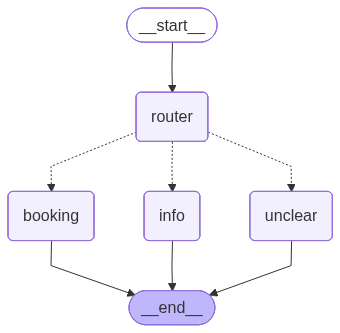

In [17]:
from IPython.display import display, Markdown, Image

graph = create_agent_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
def run_demo():
    """
    Demonstrates the agent routing system with various test cases.
    """
    app = create_agent_graph()

    test_cases = [
        "I want to book a table for 4 people tonight at 7pm",
        "What are your business hours?",
        "Hello, can you help me?",
        "How much does the premium package cost?",
        "I need to schedule an appointment for next Tuesday",
        "Where is your office located?",
        "Thanks!",
        "I want to reserve a hotel room for the weekend"
    ]

    print("=" * 80)
    print("AGENT ROUTING SYSTEM DEMO - LLM Powered")
    print("=" * 80)

    for i, user_input in enumerate(test_cases, 1):
        print(f"\n{'=' * 80}")
        print(f"TEST CASE {i}/{len(test_cases)}")
        print(f"{'=' * 80}")
        print(f"👤 User: {user_input}")

        initial_state = {
            "user_input": user_input,
        }

        result = app.invoke(initial_state)

        print(f"\n🤖 Agent Response:")
        print(f"   {result['response']}")

        if result.get('needs_followup'):
            print(f"\n   ⚠️  Follow-up needed")

        print(f"\n{'─' * 80}")




In [19]:
run_demo()



AGENT ROUTING SYSTEM DEMO - LLM Powered

TEST CASE 1/8
👤 User: I want to book a table for 4 people tonight at 7pm


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: booking


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🎫 BOOKING AGENT → Generated response

🤖 Agent Response:
   Sure! I'd be happy to help you reserve a table for 4 people tonight at 7 pm. Could you let me know which restaurant you'd like to dine at, and if you have a preferred contact number or email for the confirmation? Once I have those details, I’ll lock in the reservation for you.

────────────────────────────────────────────────────────────────────────────────

TEST CASE 2/8
👤 User: What are your business hours?


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: info


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



ℹ️  INFO AGENT → Generated response

🤖 Agent Response:
   Our business hours are Monday‑Friday 9 AM–6 PM, Saturday 10 AM–4 PM, and we are closed on Sundays. Let me know if you need anything else!

────────────────────────────────────────────────────────────────────────────────

TEST CASE 3/8
👤 User: Hello, can you help me?


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: unclear


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🤔 CLARIFICATION AGENT → Generated response

🤖 Agent Response:
   Hello! I’d love to help you out. Could you let me know what you’re looking for? Here are a few ways I can assist:

1. **Booking services** – e.g., restaurants, hotels, or appointments.
2. **Information requests** – e.g., hours, location, pricing, or services.
3. **General assistance and guidance** – e.g., travel tips, recommendations, or anything else you have in mind.

Just let me know which one (or more) sounds right, or feel free to describe what you need!

────────────────────────────────────────────────────────────────────────────────

TEST CASE 4/8
👤 User: How much does the premium package cost?


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: info


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



ℹ️  INFO AGENT → Generated response

🤖 Agent Response:
   The premium package costs $150. Let me know if you need help with anything else.

────────────────────────────────────────────────────────────────────────────────

TEST CASE 5/8
👤 User: I need to schedule an appointment for next Tuesday


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: booking


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🎫 BOOKING AGENT → Generated response

🤖 Agent Response:
   Sure! I'd be happy to help you schedule your appointment for next Tuesday. Could you let me know a few details so I can get everything set up?

1. **Preferred time** – Do you have a specific time in mind, or would you like me to suggest a few available slots?
2. **Number of people** – How many people will be attending the appointment?
3. **Type of appointment** – Is this a consultation, a service visit, a meeting, or something else?
4. **Any special requests** – Do you need a particular room, equipment, or anything else?

Once I have this information, I’ll confirm the exact date and time, provide a confirmation number, and let you know what to expect next. Looking forward to hearing from you!

────────────────────────────────────────────────────────────────────────────────

TEST CASE 6/8
👤 User: Where is your office located?


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: info


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



ℹ️  INFO AGENT → Generated response

🤖 Agent Response:
   A helpful message only

────────────────────────────────────────────────────────────────────────────────

TEST CASE 7/8
👤 User: Thanks!


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: unclear


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🤔 CLARIFICATION AGENT → Generated response

🤖 Agent Response:
   Hi! I'm here to help. Here are a few ways I can assist you:

1️⃣ **Book a restaurant, hotel, or appointment** – I can find options and reserve them for you.
2️⃣ **Provide information** – hours, location, pricing, services, or anything else you need to know.
3️⃣ **General assistance & guidance** – anything else you’re curious about or need help with.

Which of these would you like to explore? Let me know!

────────────────────────────────────────────────────────────────────────────────

TEST CASE 8/8
👤 User: I want to reserve a hotel room for the weekend


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🧭 ROUTER → Routing to: booking


/tmp/ipython-input-1076811982.py:10: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return init_chat_model(



🎫 BOOKING AGENT → Generated response

🤖 Agent Response:
   Sure thing! I’d be happy to help you reserve a hotel room for the weekend. To get started, could you let me know the following details?

1. **Check‑in date** (e.g., Saturday, Oct 12)
2. **Check‑out date** (e.g., Monday, Oct 14)
3. **Number of guests** (adults and children)
4. **Room type** you’d like (single, double, suite, etc.)
5. Any **special requests** (e.g., non‑smoking, high floor, early check‑in)

Once I have that information, I’ll look up availability and walk you through the booking process. Looking forward to hearing from you!

────────────────────────────────────────────────────────────────────────────────
